## Smart detection with blocks knowledge 

In [7]:
%matplotlib inline
import csv
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
import numpy as np

### Analysis of Trustchain Database

In [159]:
tx_store = {}
inverted_seen = {}
# Read trustchain transactions
with open("PeerTrustchainLedgers/database_blocks_agg.csv") as read_file:
    first = True
    csv_reader = csv.reader(read_file)
    first = True
    for row in csv_reader:
        if first:
            first = False
        else:
            # time, transaction, seq_num, link, seen_by 
            tx = ast.literal_eval(row[0])
            seq_num = int(row[1])
            link = int(row[2])
            seen_by = int(row[3])
            
            if seen_by not in inverted_seen.keys():
                inverted_seen[seen_by] = set()
                
            tx_id = str(tx['from_peer'])+"_"+str(seq_num)
            if tx_id not in tx_store.keys():
                tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": set()}
            if link != 0:
                # This is confirmation for the transaction
                tx_id = str(tx['from_peer'])+"_"+str(link)
                try:
                    tx_store[tx_id]["seen_confirm"].add(seen_by)
                except KeyError as e:
                    tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": {seen_by}}
                    
                tx_store[tx_id]["tx"]["seq"] = link
                tx_store[tx_id]["tx"]["link"] = seq_num
                # Send 
                tx_id_inv = str(tx['to_peer']) + "_" + str(seq_num)
                tx_store[tx_id_inv] = tx_store[tx_id]
                inverted_seen[seen_by].add(tx_id)
                inverted_seen[seen_by].add(tx_id_inv)
            else:
                tx_store[tx_id]["seen"].add(seen_by)
                inverted_seen[seen_by].add(tx_id)


In [160]:
inverted_seen_gt = inverted_seen.copy()
tx_store_gt = tx_store.copy()

In [166]:
# Construct overlay network:
import ast
tx_store = {}
inverted_seen = {}


G = nx.Graph()
with open("PeerTrustchainLedgers/peer_connections_1.txt") as read_file:
    first = True
    for vals in read_file.readlines():
        if first:
            first = False
        else:
            peer_a, peer_b = vals.split(',')
            G.add_edge(int(peer_a), int(peer_b))

# Read trustchain transactions
with open("PeerTrustchainLedgers/leader_blocks_time_agg.csv") as read_file:
    first = True
    csv_reader = csv.reader(read_file)
    first = True
    for row in csv_reader:
        if first:
            first = False
        else:
            # time, transaction, seq_num, link, seen_by 
            tx = ast.literal_eval(row[1])
            seq_num = int(row[2])
            link = int(row[3])
            tx_id = str(tx['from_peer'])+"_"+str(seq_num)
            seen_by = int(row[4])
            if seen_by not in inverted_seen.keys():
                inverted_seen[seen_by] = set()
            if tx_id not in tx_store.keys():
                tx_store[tx_id] = {"tx":tx, "seen": set(), "seen_confirm": set()}
            if link != 0:
                # This is confirmation for the transaction
                tx_id = str(tx['from_peer'])+"_"+str(link)
                tx_store[tx_id]["seen_confirm"].add(seen_by)
                tx_store[tx_id]["tx"]["seq"] = link
                tx_store[tx_id]["tx"]["link"] = seq_num
                # Send 
                tx_id_inv = str(tx['to_peer']) + "_" + str(seq_num)
                tx_store[tx_id_inv] = tx_store[tx_id]
                inverted_seen[seen_by].add(tx_id)
                inverted_seen[seen_by].add(tx_id_inv)
            else:
                tx_store[tx_id]["seen"].add(seen_by)
                inverted_seen[seen_by].add(tx_id)

set()

In [171]:
tx_store_gt['40_93']['seen_confirm'] - tx_store['40_93']['seen_confirm']

set()

In [9]:
# Process seen transactions
# Seen by peer with id 
peer_id = 92
# all transactions seen by 
peer_knows_peer = {}


for tx in sorted(inverted_seen[peer_id], key=lambda tx_id: int(tx_id.split('_')[1])):
    #if int(tx.split('_')[0]) == peer_id:
    #    continue 
    # to peer knows about the from_peer
    # This is confirmation block 
    if tx_store[tx]['tx']['link'] == int(tx.split('_')[1]):
        
        f_peer  = int(tx_store[tx]['tx']['from_peer'])
        t_peer = int(tx_store[tx]['tx']['to_peer'])
        
        if f_peer not in peer_knows_peer.keys():
            peer_knows_peer[f_peer] = {}
        if t_peer not in peer_knows_peer.keys():
            peer_knows_peer[t_peer] = {}
        
        if t_peer not in peer_knows_peer[f_peer].keys():
            peer_knows_peer[f_peer][t_peer] = set()
        peer_knows_peer[f_peer][t_peer].add(tx_store[tx]['tx']["seq"])
            
        if f_peer not in peer_knows_peer[t_peer].keys():
            peer_knows_peer[t_peer][f_peer] = set()
        peer_knows_peer[t_peer][f_peer].add(tx_store[tx]['tx']["link"])
    else:
        f_peer  = int(tx_store[tx]['tx']['from_peer'])
        t_peer = int(tx_store[tx]['tx']['to_peer'])
        
        if f_peer not in peer_knows_peer.keys():
            peer_knows_peer[f_peer] = {}
        if t_peer not in peer_knows_peer.keys():
            peer_knows_peer[t_peer] = {}
        
        if t_peer not in peer_knows_peer[f_peer].keys():
            peer_knows_peer[f_peer][t_peer] = set()
            
        peer_knows_peer[f_peer][t_peer].add(tx_store[tx]['tx']["seq"])
            

In [107]:
def compress_blocks(blocks):
    array = [0 for _ in range(200)]
    for b in blocks:
        for i in range (b[0], b[1]+1):
            array[i] = 1
    new_blocks = []
    last_open = 0
    opened_block = False
    last_closed = 0
    for k in range(200):
        if array[k] == 1:
            if not opened_block:
                opened_block = True
                last_open = k
            last_closed = k 
        else:
            if opened_block:
                opened_block = False
                new_blocks.append((last_open, last_closed))
    return new_blocks, array
    

In [35]:
peer_knows_peer[1][81]

{53, 77, 86}

In [82]:
np.logical_or([1,0,1], [0,1,0])

array([ True,  True,  True])

In [101]:
set(G.neighbors(92))

{1, 3, 6, 7, 15, 24, 49, 54, 63, 64, 68, 82, 86, 87, 96, 99}

In [114]:
def find_last_sig_bit(mask):
    index = len(mask)-1
    while not mask[index]:
        index -= 1
    return index

In [131]:
wv_peer  = peer_id
target_peer = 1
window = 5

peers_labels = peer_knows_peer[target_peer].keys()
peers_num =  len(peer_knows_peer[target_peer].keys())

inp = ""
full_mask = [0 for _ in range(200)]

for p in peers_labels:
    blocks = [(max(k-window, 0),k) for k in peer_knows_peer[target_peer][p]]
    new_blocks, array_mask = compress_blocks(blocks)
    full_mask = np.logical_or(full_mask, array_mask)
    for b in new_blocks:
        inp = inp + str(p) + str(",") + str(b[0])+str(",")+str(b[1])+str(",")+str("In") + "\n"

last_index = find_last_sig_bit(full_mask)
full_mask = full_mask[:last_index]
number_of_holes = len(np.where(full_mask == False)[0])

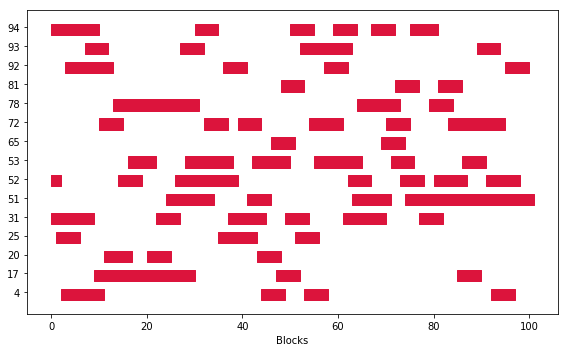

In [132]:
import pandas as pd
import io
import matplotlib.pyplot as plt

df = pd.read_csv(io.StringIO(inp), header=None, names=["Task", "Start", "Finish", "Resource"] )
df["Diff"] = df.Finish - df.Start

color = {"In":"crimson", "Out":"crimson"}
fig,ax=plt.subplots(figsize=(8,5))

labels=[]
for i, task in enumerate(df.groupby("Task")):
    labels.append(task[0])
    for r in task[1].groupby("Resource"):
        data = r[1][["Start", "Diff"]]
        ax.broken_barh(data.values, (i-0.4,0.6), color=color[r[0]] )

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels) 
ax.set_xlabel("Blocks")
plt.tight_layout()       
plt.show()

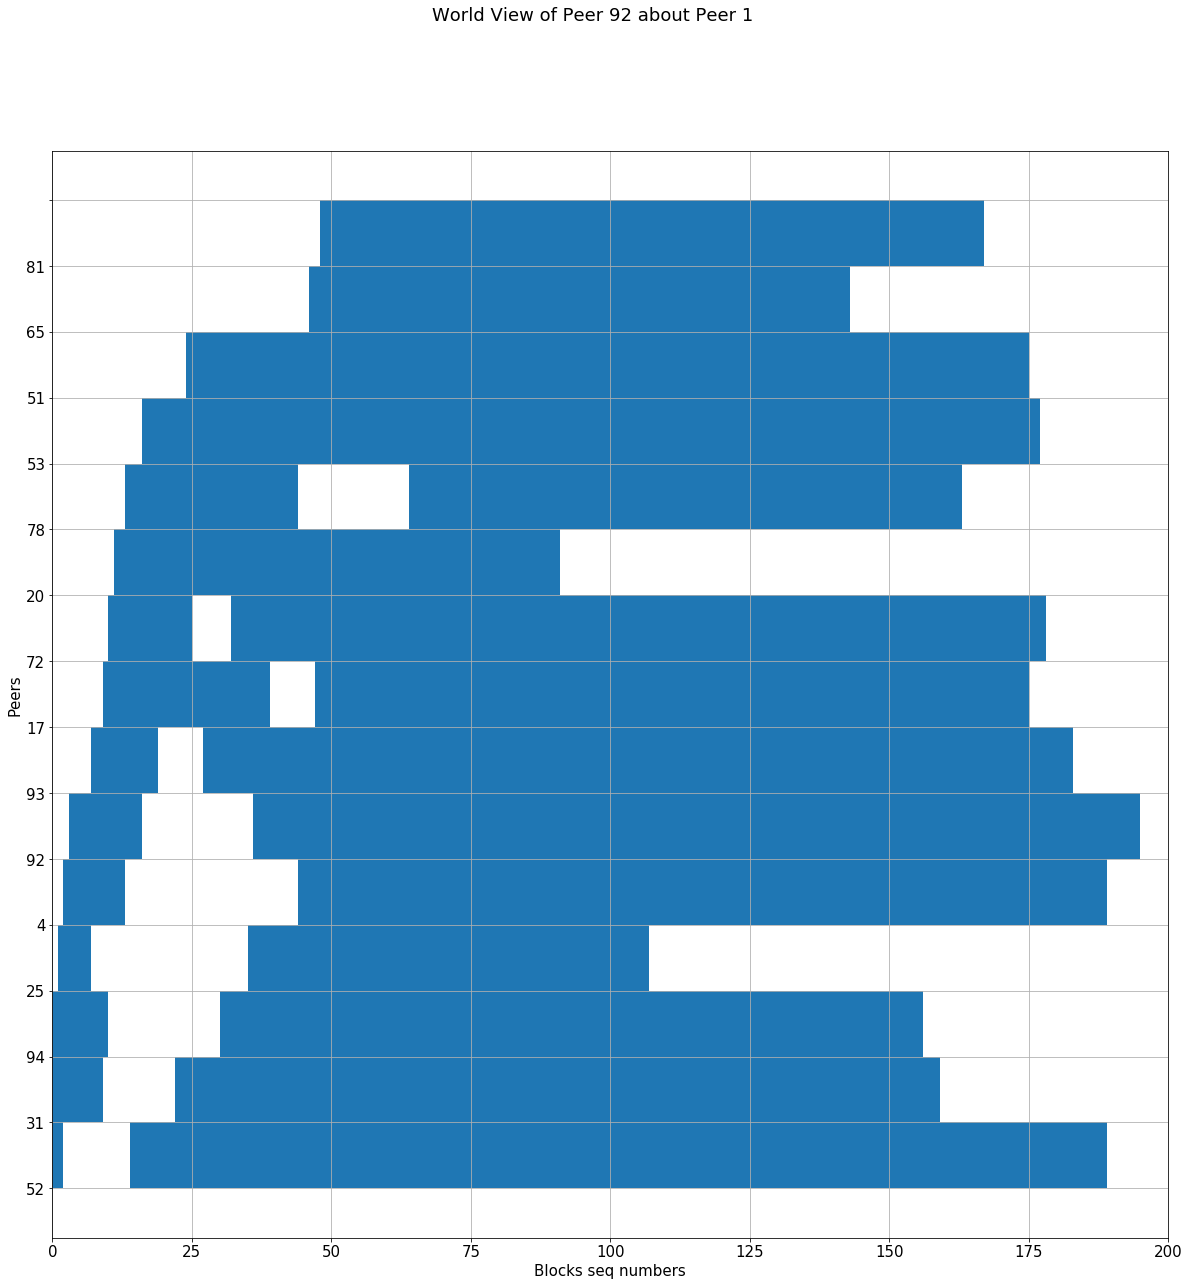

In [48]:
# Declaring a figure "gnt" 
fontsize = 15
wv_peer  = peer_id
target_peer = 1
window = 5



fig, gnt = plt.subplots(figsize=(20,20)) 

fig.suptitle('World View of Peer {} about Peer {}'.format(peer_id, target_peer), fontsize=fontsize+3)

# Setting Y-axis limits 
#gnt.set_ylim(0, 100)
  
# Setting X-axis limits 
gnt.set_xlim(0, 200) 
  
# Setting labels for x-axis and y-axis 
gnt.set_xlabel('Blocks seq numbers', fontsize=fontsize) 
gnt.set_ylabel('Peers', fontsize=fontsize) 
  
# Setting ticks on y-axis 
gnt.set_yticks(range(1,(peers_num+2)*1,1)) 
# Labelling tickes of y-axis 
gnt.set_yticklabels(peers_labels, fontsize=fontsize) 

for tick in gnt.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize) 

# Setting graph attribute 
gnt.grid(True) 


index = 1
for p in list(peers_labels):
    blocks = [(max(k-window, 0),k) for k in peer_knows_peer[target_peer][p]]
    new_blocks = compress_blocks(blocks)
    gnt.broken_barh(new_blocks, (1*index, 1), 
                                  facecolors =('tab:blue'))
    index+=1
    
  


In [118]:
peer_knows_peer[32]

{54: {5, 33, 81},
 64: {10, 73, 76},
 15: {11, 19, 75},
 66: {12},
 70: {18, 50},
 24: {23, 35, 53},
 97: {45},
 99: {46, 48, 83, 87},
 86: {55},
 21: {56}}

In [119]:
peer_knows_peer[24]

{92: {1, 15, 39, 45, 47, 57, 59, 96},
 43: {3, 17, 20, 37, 100},
 89: {4, 7, 97},
 98: {5, 36, 42, 69, 116},
 86: {6, 56, 106, 107},
 41: {8, 83, 109},
 75: {9, 13, 16, 26, 38, 72, 82},
 26: {10, 49, 62, 93, 114},
 83: {12, 18, 24, 41, 46, 66, 113},
 91: {14, 21, 104},
 49: {19, 29, 53},
 20: {25, 30, 55, 68, 112},
 11: {27, 85},
 14: {31, 40, 70, 103},
 88: {33, 34, 99, 102},
 32: {35, 48, 80},
 10: {43, 48, 54},
 78: {44, 52, 63, 71, 76, 81, 90, 94},
 62: {50, 58, 65},
 66: {67, 86, 115},
 34: {73, 74, 79, 108},
 84: {75, 87, 117},
 60: {92, 110},
 63: {95}}

In [114]:
set(G.neighbors(24))  - set(peer_knows_peer[24].keys())

{47, 55}

In [108]:
peer_knows_peer[47]

{54: [11, 23, 23, 59, 83, 115],
 86: [19, 97, 106, 108, 112],
 65: [34],
 96: [28, 68],
 87: [67, 79, 102, 77, 77, 116],
 45: [85],
 53: [90],
 99: [94, 117]}

In [102]:
set(G.neighbors(92))

{1, 3, 6, 7, 15, 24, 49, 54, 63, 64, 68, 82, 86, 87, 96, 99}

In [112]:
tx_store["24_7"]

{'tx': {'down': 641728512,
  'to_peer': '89',
  'from_peer': 24,
  'up': 625999872,
  'seq': 7,
  'link': 11},
 'seen': {8,
  9,
  10,
  11,
  12,
  14,
  17,
  20,
  24,
  26,
  30,
  32,
  34,
  35,
  39,
  41,
  43,
  47,
  49,
  51,
  54,
  60,
  62,
  63,
  64,
  65,
  66,
  68,
  73,
  75,
  76,
  77,
  78,
  79,
  83,
  84,
  86,
  88,
  89,
  90,
  91,
  92,
  97,
  98},
 'seen_confirm': {8,
  9,
  12,
  17,
  24,
  30,
  35,
  39,
  49,
  51,
  54,
  62,
  64,
  65,
  68,
  73,
  76,
  77,
  79,
  83,
  86,
  88,
  90,
  92,
  97,
  98}}

In [97]:
peer_knows_peer[24]

{92: [1, 15, 45, 39, 59, 47, 57, 96],
 43: [3, 3, 17, 20, 37],
 98: [5, 116],
 86: [6, 56, 106, 107],
 41: [8, 83],
 75: [9, 13, 38, 72],
 26: [10, 10, 62, 93, 114],
 89: [7, 97],
 91: [14, 21, 104],
 49: [19, 29, 53],
 20: [25, 30, 68, 112],
 11: [27],
 14: [31, 40, 103],
 88: [33, 34],
 32: [35, 48, 80],
 83: [41, 46, 66],
 78: [44, 52, 63, 76, 90, 90, 94],
 10: [48],
 62: [50, 65],
 34: [73, 108],
 84: [75, 117],
 66: [86],
 63: [95, 95]}

In [95]:
peer_knows_peer[24]

{92: [1, 45, 59, 96], 20: [55], 78: [71, 81, 90]}

In [87]:
tx_store["24_55"]

{'tx': {'down': 862978048,
  'to_peer': '20',
  'from_peer': 24,
  'up': 956301312,
  'seq': 55,
  'link': 38},
 'seen': {1,
  11,
  12,
  13,
  14,
  20,
  21,
  24,
  26,
  31,
  32,
  34,
  37,
  41,
  43,
  47,
  55,
  58,
  60,
  62,
  63,
  66,
  70,
  71,
  75,
  78,
  83,
  84,
  86,
  88,
  89,
  91,
  92,
  98},
 'seen_confirm': {1,
  12,
  13,
  20,
  21,
  24,
  31,
  37,
  41,
  47,
  58,
  60,
  70,
  71,
  75,
  91}}

In [94]:
tx_store["91_108"]

{'tx': {'down': 649068544,
  'to_peer': '20',
  'from_peer': 91,
  'up': 262144000,
  'seq': 108,
  'link': 86},
 'seen': {1,
  8,
  12,
  13,
  17,
  18,
  20,
  21,
  24,
  28,
  29,
  31,
  37,
  41,
  43,
  45,
  47,
  48,
  53,
  56,
  58,
  60,
  70,
  71,
  75,
  80,
  87,
  91,
  99},
 'seen_confirm': {1,
  12,
  13,
  20,
  21,
  24,
  31,
  37,
  41,
  47,
  58,
  60,
  70,
  71,
  75,
  91}}

In [93]:
peer_knows_peer[91]

{17: [4], 20: [6, 33, 39, 96, 104, 108], 53: [32, 43, 62, 71, 110, 105]}

In [85]:
peer_knows_peer[24]

{92: [1, 45, 59, 96], 20: [55], 78: [71, 81, 90]}

In [83]:
peer_knows_peer[24][92]

[1, 45, 59, 96]

In [84]:
peer_knows_peer[92][24]

[2, 35, 45, 75]

In [35]:
set(G.neighbors(1))

{4, 17, 20, 25, 31, 51, 52, 53, 65, 72, 78, 81, 92, 93, 94}

In [32]:
tx_store['1_1']["seen"]-tx_store['1_1']["seen_confirm"]

{4, 17, 20, 25, 51, 53, 65, 78, 81, 92, 94}

In [47]:
tx_store['68_1']

{'tx': {'down': 834666496,
  'to_peer': '37',
  'from_peer': 68,
  'up': 858783744,
  'seq': 1,
  'link': 2},
 'seen': {2,
  3,
  5,
  8,
  9,
  11,
  15,
  16,
  20,
  25,
  29,
  37,
  39,
  42,
  44,
  49,
  52,
  53,
  55,
  56,
  61,
  67,
  68,
  69,
  72,
  74,
  75,
  76,
  79,
  83,
  84,
  91,
  92,
  98},
 'seen_confirm': {2,
  5,
  15,
  16,
  20,
  29,
  37,
  39,
  42,
  44,
  55,
  56,
  61,
  67,
  68,
  72,
  75,
  76,
  79,
  83,
  91,
  98}}

In [44]:
tx_store['2_2']

{'tx': {'down': 11534336,
  'to_peer': '68',
  'from_peer': 2,
  'up': 451936256,
  'seq': 2,
  'link': 5},
 'seen': {2,
  3,
  4,
  8,
  9,
  10,
  11,
  15,
  19,
  25,
  29,
  30,
  34,
  35,
  37,
  42,
  43,
  44,
  49,
  52,
  53,
  55,
  59,
  62,
  63,
  64,
  66,
  68,
  69,
  73,
  74,
  77,
  84,
  88,
  92},
 'seen_confirm': {2,
  3,
  8,
  9,
  11,
  25,
  29,
  37,
  42,
  44,
  49,
  52,
  53,
  55,
  68,
  69,
  74,
  84,
  92}}

In [43]:
set(G.neighbors(2)) & tx_store['2_1']['seen']  # tx_store['2_1']['seen_confirm']

{4,
 10,
 11,
 15,
 19,
 29,
 30,
 34,
 35,
 37,
 42,
 43,
 55,
 59,
 62,
 63,
 64,
 66,
 68,
 73,
 77,
 88}

In [36]:
tx_store['1_1']["seen_confirm"]

{1, 9, 11, 19, 31, 38, 43, 45, 50, 52, 57, 58, 68, 72, 74, 76, 93, 97, 99}

In [2]:
# Load a snapshot of a network 
G = nx.read_gpickle('trustchain.pickle')

## Peers interaction simulation

In [3]:
from ledger import Transaction, MergeSet

In [4]:
peer_list = list(G.nodes())
peer_state = {}
for p in peer_list:
    # Initailize ledgers
    peer_state[p] = MergeSet(G.neighbors(p))

In [ ]:
# System chooses some inital peers to share inital tokens - SYSTEM genesis
init_peers = np.random.choice(peer_list,100, replace=False)
for p1 in init_peers: 
    # inital transaction
    tx = Transaction("SYSTEM", p1, "valid", p1+"v0", [0], 1)
    peer_state[p1].store_transaction(tx)
    if not peer_state[p1].is_malicious: 
        # Share transaction with neighbours 
        peer_state[p1].overlay_neighbours
    




In [6]:

# Assume that peer knows all 1-hop neighbours 
# Test 1000 transactions on one specific peer
target_peer = np.random.choice(peer_list, replace=False)
TX_COUNT = 1000

# No consistency 
# Eventual consistency 
# Casual consistency 
# Strong consistency 




for i in range()



## Set-reconcilation with cuckoo filters

### One filter per account?

The performance of the filter will degrade with more values inserted. 
To improve performance we need to introduce moving window of the elements, or limit the number of transactions. 

Filter will be filled with transaction id/hash. 

Having a filter and a new transaction one can check quickly if the transacion is inserted in the right time. 
Bloom clock 



## Transaction 

Transaction is a state transaction of a Peer A from $T_k: s_k -> s_{k+1}$. 

State can be represented as a Bloom clock? Counting Bloom Filter or Cuckoo filter

Each peer has own clock, event happend can be computed -> $H_k(B)+=1$ for each $H_k$. This will update certain cells in the clock. 

Transactions with different peers can be executed concurrently and later merged. 
